In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time

from reduced_basis import *

np.random.seed(42)

<h3> A more interesting geometry </h3>

Up to now we have only used an example defined on a square. Now we want to look at a geometry that is a little bit more interesting. We construct a simple 2d model of a glass bottle surrounded with air and will interpret the solution $u$ as a sound wave. To simulate a frameless environment, we use absorbing (Robin) boundaries on the edges of the rectangle. The sound reflecting properties of the glass are enforced via Neumann boundaries. 

In [2]:
from netgen.geom2d import *
import time

geo = SplineGeometry()

r1 = 1.25
r2 = 0.35
h1 = 5
h2 = 1.5
h3 = 0.5
d = 0.2


x_val = [0, 2*r1, 2*r1, r1+r2, r1+r2, r1+r2-d, r1+r2-d, 2*r1-d, 2*r1-d, d, d, r1-r2+d, r1-r2+d, r1-r2, r1-r2, 0]
y_val = [0, 0, h1, h1+h2, h1+h2+h3, h1+h2+h3, h1+h2, h1, d, d, h1, h1+h2, h1+h2+h3, h1+h2+h3, h1+h2, h1]

assert len(x_val)==len(y_val), "lengths of x and y values must be the same"
points = [None]*len(x_val)
amount_points = len(points)
for j in range(0,amount_points):
    points[j] = geo.AppendPoint(x_val[j], y_val[j])

for j in range(0,amount_points):
    geo.Append(["line", points[j], points[(j+1) % amount_points]], leftdomain=0, rightdomain=1, bc = "bottle")

geo.AddRectangle((-1,-1),(2*r1+1, h1+h2+h3+1),bc="robin")
geo.SetMaterial (1, "air")


mesh = Mesh(geo.GenerateMesh(maxh=0.2))

fes = H1(mesh, order=3, complex=True, definedon="air")
u,v = fes.TnT()

## peak on top of bottle
func1 = 1e5*exp(-(50**2)*((x-r1)**2 + (y-(h1+h2+h3+0.3))**2)) *v*dx

## peak left from bottle
func2 = 1e5*exp(-(50**2)*((x-r2)**2 + (y-(h1+h2+h3+0.3))**2)) *v*dx

## peak right from bottle
func3 = 1e5*exp(-(50**2)*((x-(r1+r2))**2 + (y-(h1+h2+h3+0.3))**2)) *v*dx

## peak in the bottle
func4 = 1e5*exp(-(50**2)*((x-r1)**2 + (y-(r2+0.5))**2)) *v*dx

## peak in neck
func5 = 1e5*exp(-(50**2)*((x-r1)**2 + (y-((h1+h2+h3)/2))**2)) *v*dx

snapshots = np.arange(1,5,1)
space1 = ReducedBasis(fes, [grad(u)*grad(v)*dx, -1j*u*v *ds('robin'), -u*v *dx], func4, snapshots)

random_omegas = np.sort(np.append(np.random.uniform(space1.omega_min, space1.omega_max, 100), snapshots))


slider_func1 = lambda x: space1.draw(x, redraw=True)
space1.draw(space1.omega_min)
interact(slider_func1, x=widgets.FloatSlider(min=space1.omega_min, max=space1.omega_max, step=0.05, value=space1.omega_min))

compute Reduced Basis for snapshots  [1 2 3 4]
finished computing Reduced Basis
omega: 1, norm of solution: 17292.801482101127


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-1-g90581404c', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=1.0, description='x', max=4.0, min=1.0, step=0.05), Output()), _dom_cl…

<function __main__.<lambda>(x)>

Again we can compute and plot the norm and the residuals of several solutions in the reduced space.

 average residual: 8824.068353461817 
 amount of snapshots: 4


<IPython.core.display.Javascript object>


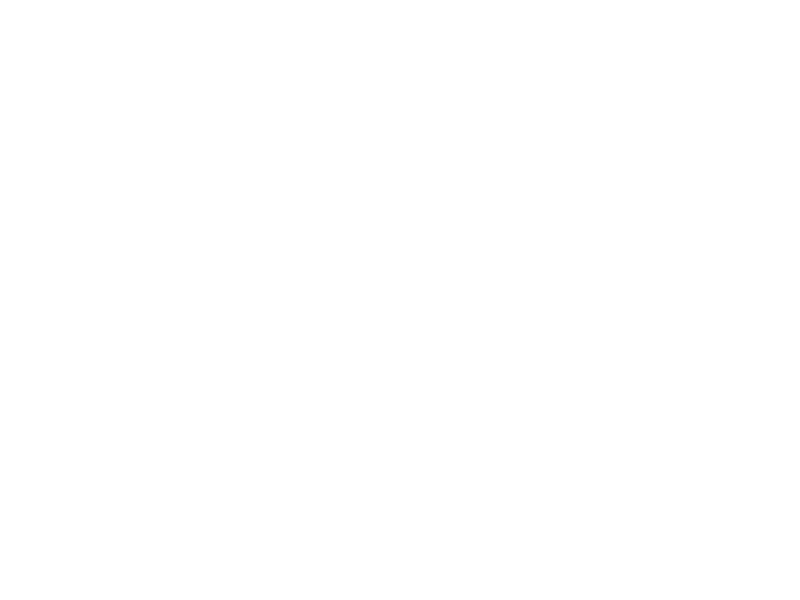

<IPython.core.display.Javascript object>


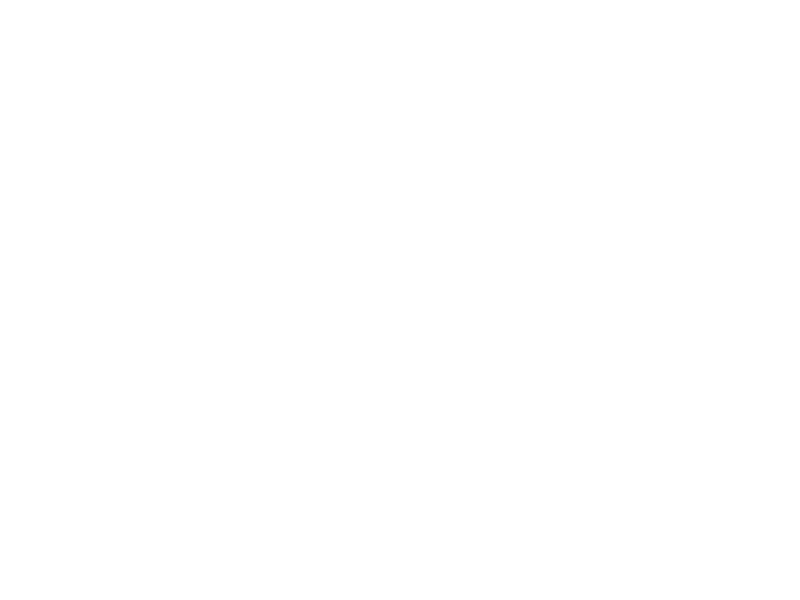

[]

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

space1.logging = False

norm_random_omegas, residual_random_omegas = space1.computeValues(random_omegas, cheap = False)

print(" average residual: {} \n amount of snapshots: {}".format(np.mean(residual_random_omegas), len(space1.getSnapshots())))

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
sn_residual = space1.computeValues(space1.getSnapshots(), norm= False, cheap = False)
ax.plot(space1.getSnapshots(), sn_residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

Overall the residuals do not look so good. We can try to achieve a better performance by using our greedy way of choosing additional snapshots again. The computation will take more time because we use higher order and complex valued basis functions.

compute Reduced Basis for snapshots  [1 2 3 4]
finished computing Reduced Basis


<IPython.core.display.Javascript object>


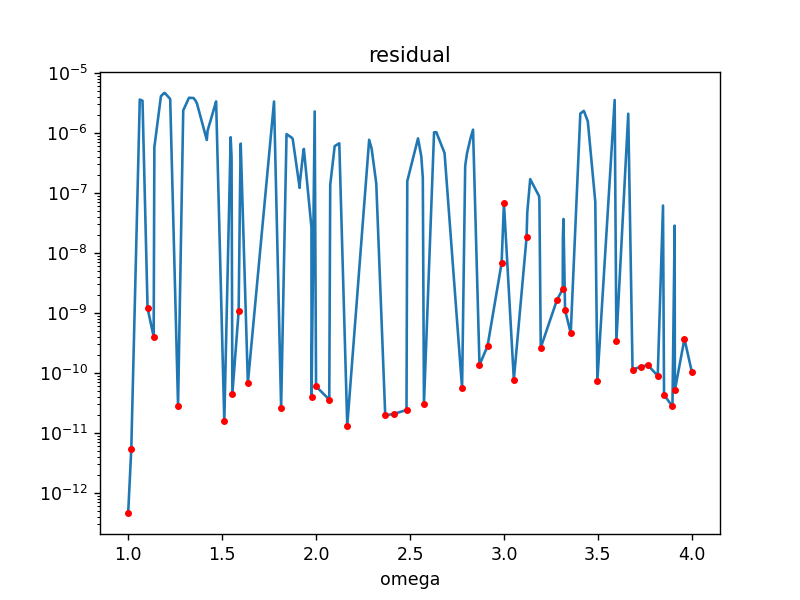

add snapshot for omega = 2.166031869068446 average residual: 8902.799996474343
add snapshot for omega = 3.2823551458506923 average residual: 243238.49126725006
add snapshot for omega = 3.1959818254342154 average residual: 538478.0629885328
add snapshot for omega = 3.497327922401265 average residual: 229222.3464607005
add snapshot for omega = 2.9875668530619457 average residual: 23404.55839464709
add snapshot for omega = 2.5742692948967134 average residual: 3010.5873279531024
add snapshot for omega = 1.8140470953216878 average residual: 1119.162672994164
add snapshot for omega = 1.5115723710618747 average residual: 1553.1430608789988
add snapshot for omega = 1.2654775061557584 average residual: 25287.89042957692
add snapshot for omega = 1.554563366576581 average residual: 594.8466102753918
add snapshot for omega = 3.120572031542851 average residual: 175.8244921909513
add snapshot for omega = 3.7656227050693505 average residual: 142.36822232371026
add snapshot for omega = 3.8521429192297

In [6]:
import time

space = ReducedBasis(fes, [grad(u)*grad(v)*dx, -1j*u*v *ds('robin'), -u*v *dx], func4, snapshots)
space.logging = False

MAX_IT = 100
THRESHOLD = 1e-5
CHEAP = True 

# initialize plot
fig_r = plt.figure()
ax_r = fig_r.add_subplot(111)
plt.ion()
fig_r.show()
fig_r.canvas.draw()

begin_time = time.time()

for i in range(MAX_IT):
        
    residual = space.computeValues(random_omegas, norm=False, cheap = CHEAP)
    
    ax_r.clear()    
    ax_r.plot(random_omegas, residual , '-')
    sn_residual = space.computeValues(space.getSnapshots(), norm = False, cheap = CHEAP)
    ax_r.plot(space.getSnapshots(), sn_residual, 'r.', label = 'snapshots')
    ax_r.set_xlabel('omega')
    ax_r.set_title('residual')
    plt.semilogy()
    
    
    if (max(residual) < THRESHOLD): 
        print("Finished after {} seconds".format(time.time()-begin_time))
        break
    
    # sort by residual (descending)
    zip_to_sort = list(zip(residual, range(len(residual))))
    sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
    index = [tup[1] for tup in sorted_zip]
    
    for i in index:
        if not random_omegas[i] in space.getSnapshots(): 
            space.addSnapshots([random_omegas[i]])
            break
    
    ax_r.plot(random_omegas[i], residual[i], 'g*', label = 'snapshot to add')
    ax_r.legend()
    
    print("add snapshot for omega = {} average residual: {}".format(random_omegas[i], np.mean(residual)))

    
    fig_r.canvas.draw()
    space.computeValues(None,residual=False,  norm = False)

    
    time.sleep(0.00001)
    

print(" average residual: {} \n amount of snapshots: {}".format(np.mean(residual), len(space.getSnapshots())))

Now we can visualize the solution in the enhanced reduced space.

In [7]:
slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)
interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-1-g90581404c', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=1.0, description='x', max=4.0, min=1.0, step=0.05), Output()), _dom_cl…

<function __main__.<lambda>(x)>

At last we can have a look at the Eigenvalues of (1) with a non zero Robin term. This means we have to find a pair $(\omega$, $x$) so that the equation

\begin{equation}
   \omega^2Mx - \omega Rx - Kx = 0
\end{equation}

holds. Through the substitution $\lambda = -\omega$ and $z = (\lambda x, x)^T$ for linearization we get the equivalent Eigenvalue Problem

\begin{equation}
\lambda
\begin{pmatrix}
-M & 0 \\
0 & I
\end{pmatrix} z
+
\begin{pmatrix}
R & -K \\
-I & 0
\end{pmatrix} z  = 0.
\end{equation}

compute norm
finished computing values


<IPython.core.display.Javascript object>


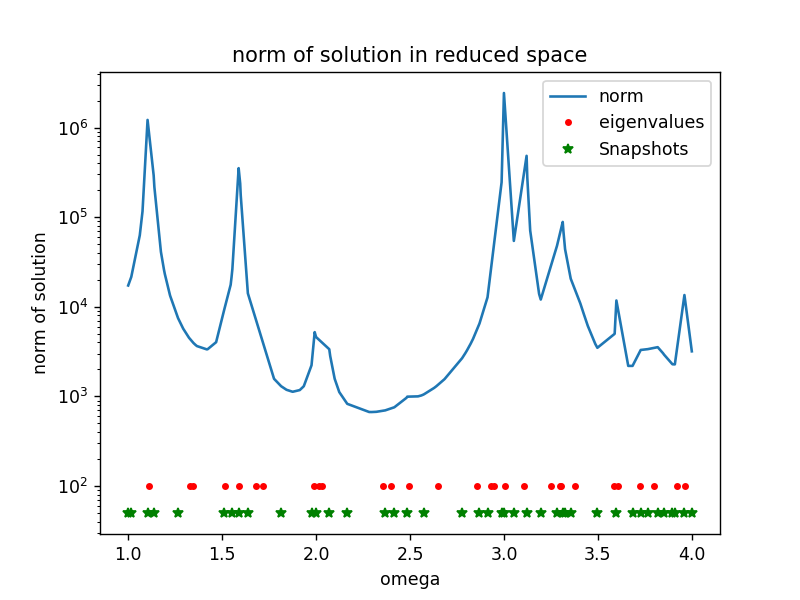

<IPython.core.display.Javascript object>


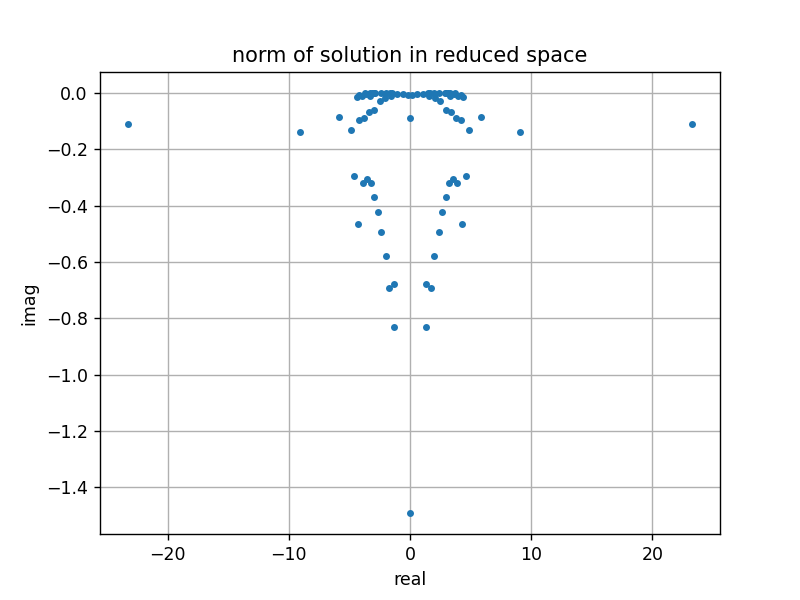

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

space.logging = True
norm_random_omegas = space.computeValues(random_omegas, residual= False)

dim = space.red[0].h
G = np.zeros((2*dim, 2*dim), dtype=complex)
C = np.zeros((2*dim, 2*dim), dtype=complex)

G[:dim, :dim] = -space.red[2].NumPy()
G[dim:, dim:] = np.identity(dim, dtype=complex)

C[:dim, :dim] = space.red[1].NumPy()
C[:dim, dim:] = -space.red[0].NumPy()
C[dim:,:dim] = -np.identity(dim, dtype=complex)

tmp = -scipy.linalg.eigvals(C, -G)
eig = np.real(tmp)
eig_re = np.real(tmp)
eig_im = np.imag(tmp)

eig = eig[eig <= space.omega_max]
eig = eig[eig >= space.omega_min]

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.plot(eig, 100*np.ones(len(eig)), 'r.', label= "eigenvalues")
ax.plot(space.getSnapshots(), 50*np.ones(len(space.getSnapshots())), 'g*',label= "Snapshots")
ax.legend()

ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()
ax.plot(eig_re, eig_im, '.')
ax.set_xlabel("real")
ax.set_ylabel("imag")
ax.set_title("norm of solution in reduced space")
plt.grid()